In [1]:
import os
import numpy as np
import glob
from tess_sip import SIP
from astropy.coordinates import SkyCoord
from astropy import units as u
import lightkurve as lk
from astroquery.mast import Tesscut
import tess_cpm
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

sys.path.insert(0, "../")
sys.path.insert(0, "../../Packages/eleanor/")
import eleanor

import warnings
warnings.filterwarnings('ignore')

from michael import janet

In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

index = uni[uni.source_id == int(2174289161681454720)].index[0]

In [3]:
j = janet.boot(uni, index=index)


In [4]:
coords = SkyCoord(ra = j.ra, dec = j.dec, unit = (u.deg, u.deg))


In [5]:
from michael.data import data_class
d = data_class(j)
d.setup_data()

Making folder /Users/oliver hall/Research/unicorn/data/output/2174289161681454720/...
Target DR3 ID 2174289161681454720 has tesscut data available on MAST for Sectors 16, 17, 56, 57
Data already downloaded for Sector 16.
Data already downloaded for Sector 17.
Data already downloaded for Sector 56.
Data already downloaded for Sector 57.


In [6]:
d.build_eleanor_lc()

In [7]:
d.build_tess_sip_lc(detrended=True)

Running pixels in aperture: 100%|█████████████| 300/300 [00:03<00:00, 89.14it/s]


In [8]:
d.build_unpopular_lc()


Removing 186 bad data points (out of 1121) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 4 bad data points (out of 1130) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 9 bad data points (out of 11775) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 11 bad data points (out of 10802) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median


In [9]:
sfiles = []
for sector in j.sectors:
    split = sector.split('-')
    if len(split) > 1:
        sfiles = []
        for s in np.arange(int(split[0]), int(split[1])+1):
            strlen = np.floor(np.log10(s)).astype(int)+1
            secstr = 's0000'[:-strlen] + str(s)

            sfile = glob.glob(f'{d.path}'+
                                f'*{secstr}*astrocut.fits')

            if len(sfile) == 0:
                raise ValueError("No tesscut files could be found for this target.")

            sfiles.append(sfile[0])

        tpflist = [lk.TessTargetPixelFile(f).cutout([26,26],13) for f in sfiles]
        tpfs = lk.TargetPixelFileCollection(tpflist)

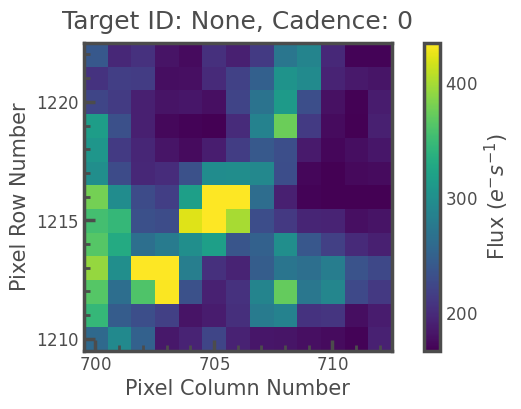

In [10]:
img = tpfs[1].plot();
plt.show()

In [11]:
lims = img.get_images()[0].get_clim()

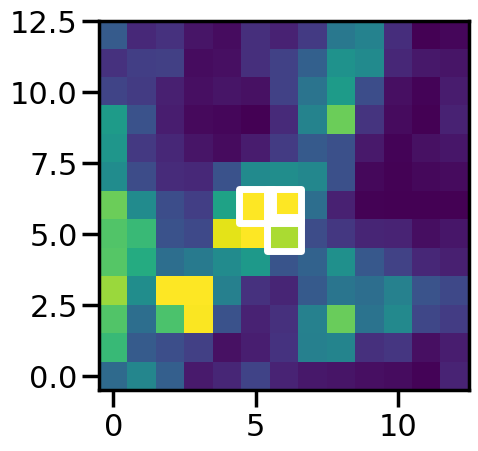

In [12]:
plt.imshow(j.void['datum_57'].tpf[0], origin='lower',
          vmin = lims[0], vmax = lims[1])
pix = np.where(j.void[f'datum_57'].aperture > 0)
plt.scatter(pix[0], pix[1], edgecolors='w', lw=5, marker=',', facecolors='none', s=600, zorder=2, label='Aperture')
plt.show()

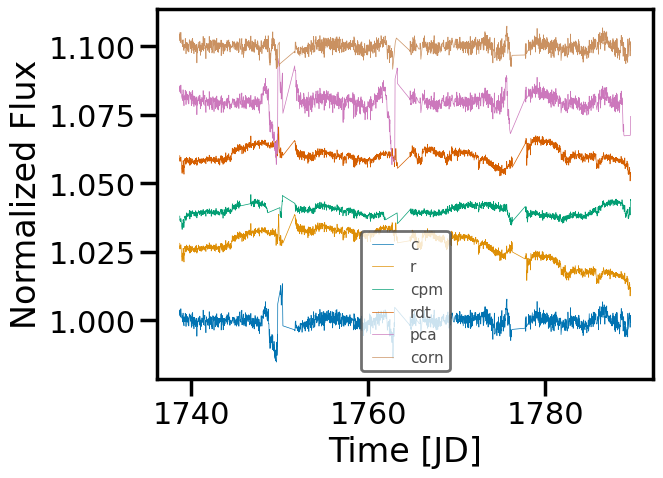

In [13]:
fig, ax = plt.subplots()
for i, m in enumerate(['c','r','cpm','rdt', 'pca','corn']):
    (j.void[f'{m}lc_16-17'] + i*.02).plot(ax=ax, label=m)
plt.show()

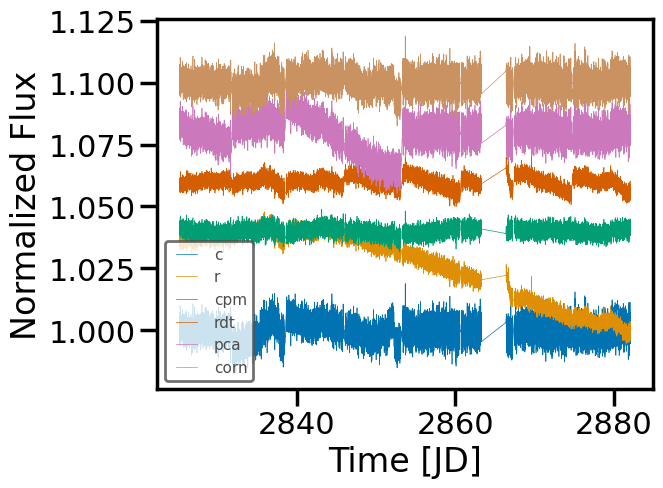

In [14]:
fig, ax = plt.subplots()
for i, m in enumerate(['c','r','cpm','rdt', 'pca','corn']):
    (j.void[f'{m}lc_56-57'] + i*.02).plot(ax=ax, label=m)
plt.show()

In [28]:
pipelines = {'eleanor' : 'c',
             'eleanor-pca' : 'pca',
             'eleanor-corner' : 'corn',
             'unpopular' : 'cpm',
             'tess-sip': 'r',
             'tess-sip-detrended' : 'rdt'}

Target DR3 ID 2174289161681454720 has tesscut data available on MAST for Sectors 16, 17, 56, 57
Data already downloaded for Sector 16.
Data already downloaded for Sector 17.
Data already downloaded for Sector 56.
Data already downloaded for Sector 57.
### Running Simple Astropy Lomb-Scargle on Sector 16-17 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16-17 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###


100%|█████████████████████████████████████████| 760/760 [00:18<00:00, 41.53it/s]


### Completed Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###
### Running Composite ACF estimation for Sector 16-17 on star 2174289161681454720 ###
### Completed Composite ACF estimation for Sector 16-17 on star 2174289161681454720 ###
### Running ACF Estimation on star 2174289161681454720 ###
### Completed ACF Estimation for Sector 16-17 on star 2174289161681454720 ###
### Running Simple Astropy Lomb-Scargle on Sector 56-57 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 56-57 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 56-57 on star 2174289161681454720 ###


100%|█████████████████████████████████████████| 848/848 [02:55<00:00,  4.84it/s]


### Completed Wavelet Estimation for Sector 56-57 on star 2174289161681454720 ###
### Running Composite ACF estimation for Sector 56-57 on star 2174289161681454720 ###
### Completed Composite ACF estimation for Sector 56-57 on star 2174289161681454720 ###
### Running ACF Estimation on star 2174289161681454720 ###
### Completed ACF Estimation for Sector 56-57 on star 2174289161681454720 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



------ Decoding Overall Period Flag 12 ------
8: One or more sectors disagrees strongly across all estimates with the others. This may indicate signal from a background star present in those sectors.
4: Only 3 or fewer of the 4 estimates of rotation agreed with one another to within 1 sigma.

No other flags raised. 



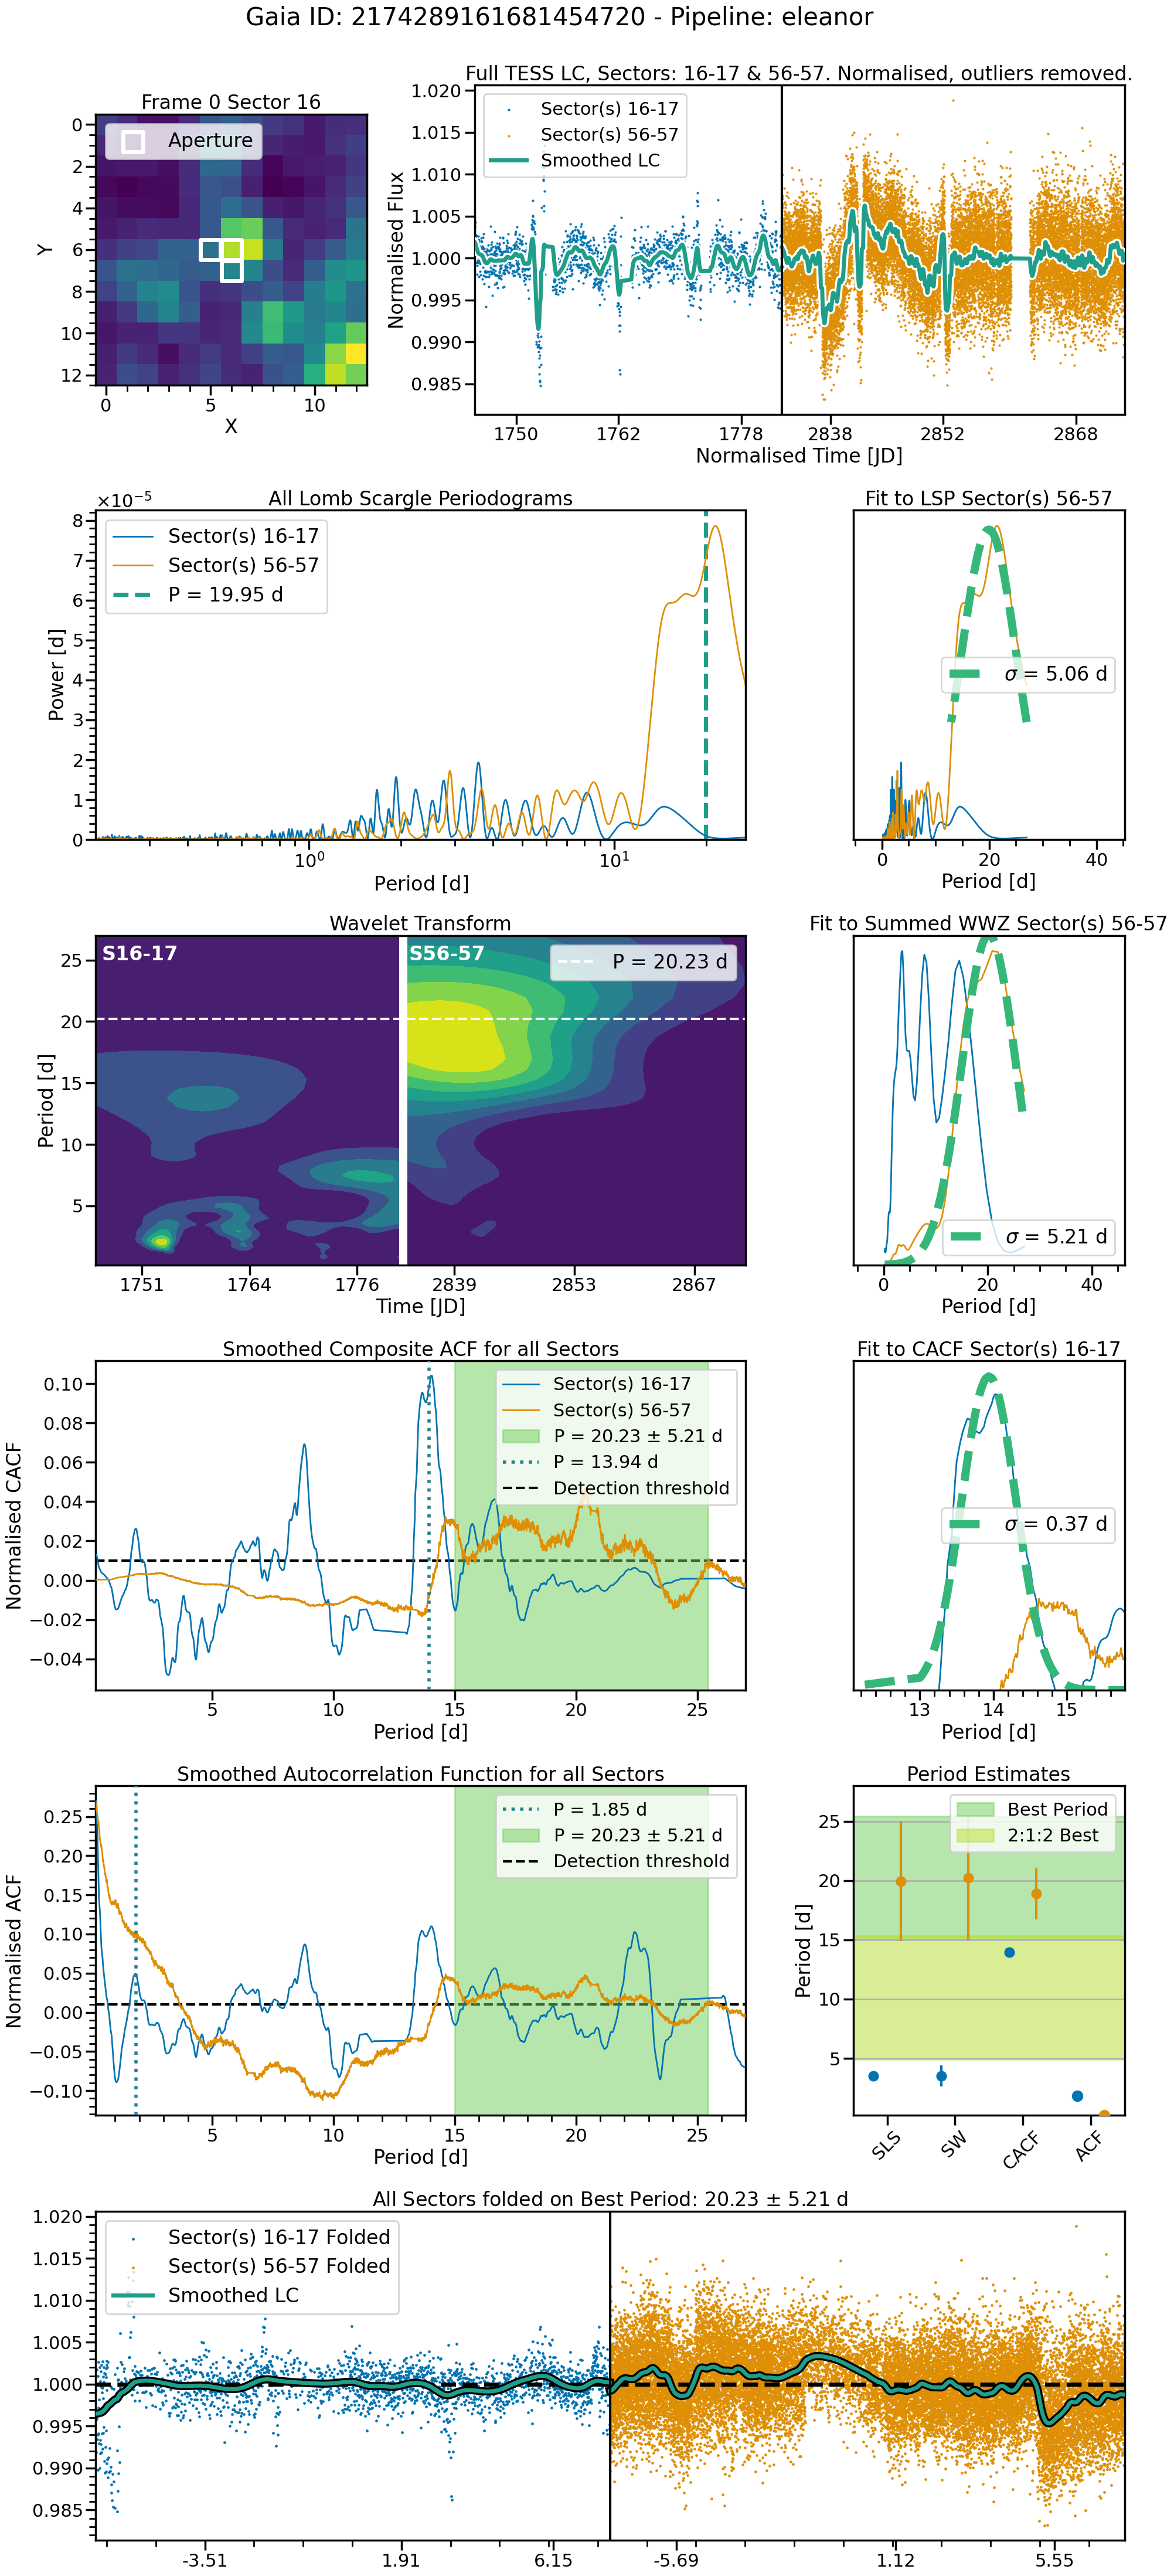

Target DR3 ID 2174289161681454720 has tesscut data available on MAST for Sectors 16, 17, 56, 57
Data already downloaded for Sector 16.
Data already downloaded for Sector 17.
Data already downloaded for Sector 56.
Data already downloaded for Sector 57.
### Running Simple Astropy Lomb-Scargle on Sector 16-17 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16-17 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###


100%|█████████████████████████████████████████| 760/760 [00:17<00:00, 42.37it/s]


### Completed Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###
### Running Composite ACF estimation for Sector 16-17 on star 2174289161681454720 ###
### Completed Composite ACF estimation for Sector 16-17 on star 2174289161681454720 ###
### Running ACF Estimation on star 2174289161681454720 ###
### Completed ACF Estimation for Sector 16-17 on star 2174289161681454720 ###
### Running Simple Astropy Lomb-Scargle on Sector 56-57 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 56-57 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 56-57 on star 2174289161681454720 ###


100%|█████████████████████████████████████████| 848/848 [02:53<00:00,  4.88it/s]


### Completed Wavelet Estimation for Sector 56-57 on star 2174289161681454720 ###
### Running Composite ACF estimation for Sector 56-57 on star 2174289161681454720 ###
### Completed Composite ACF estimation for Sector 56-57 on star 2174289161681454720 ###
### Running ACF Estimation on star 2174289161681454720 ###
### Completed ACF Estimation for Sector 56-57 on star 2174289161681454720 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



------ Decoding Overall Period Flag 12 ------
8: One or more sectors disagrees strongly across all estimates with the others. This may indicate signal from a background star present in those sectors.
4: Only 3 or fewer of the 4 estimates of rotation agreed with one another to within 1 sigma.

No other flags raised. 



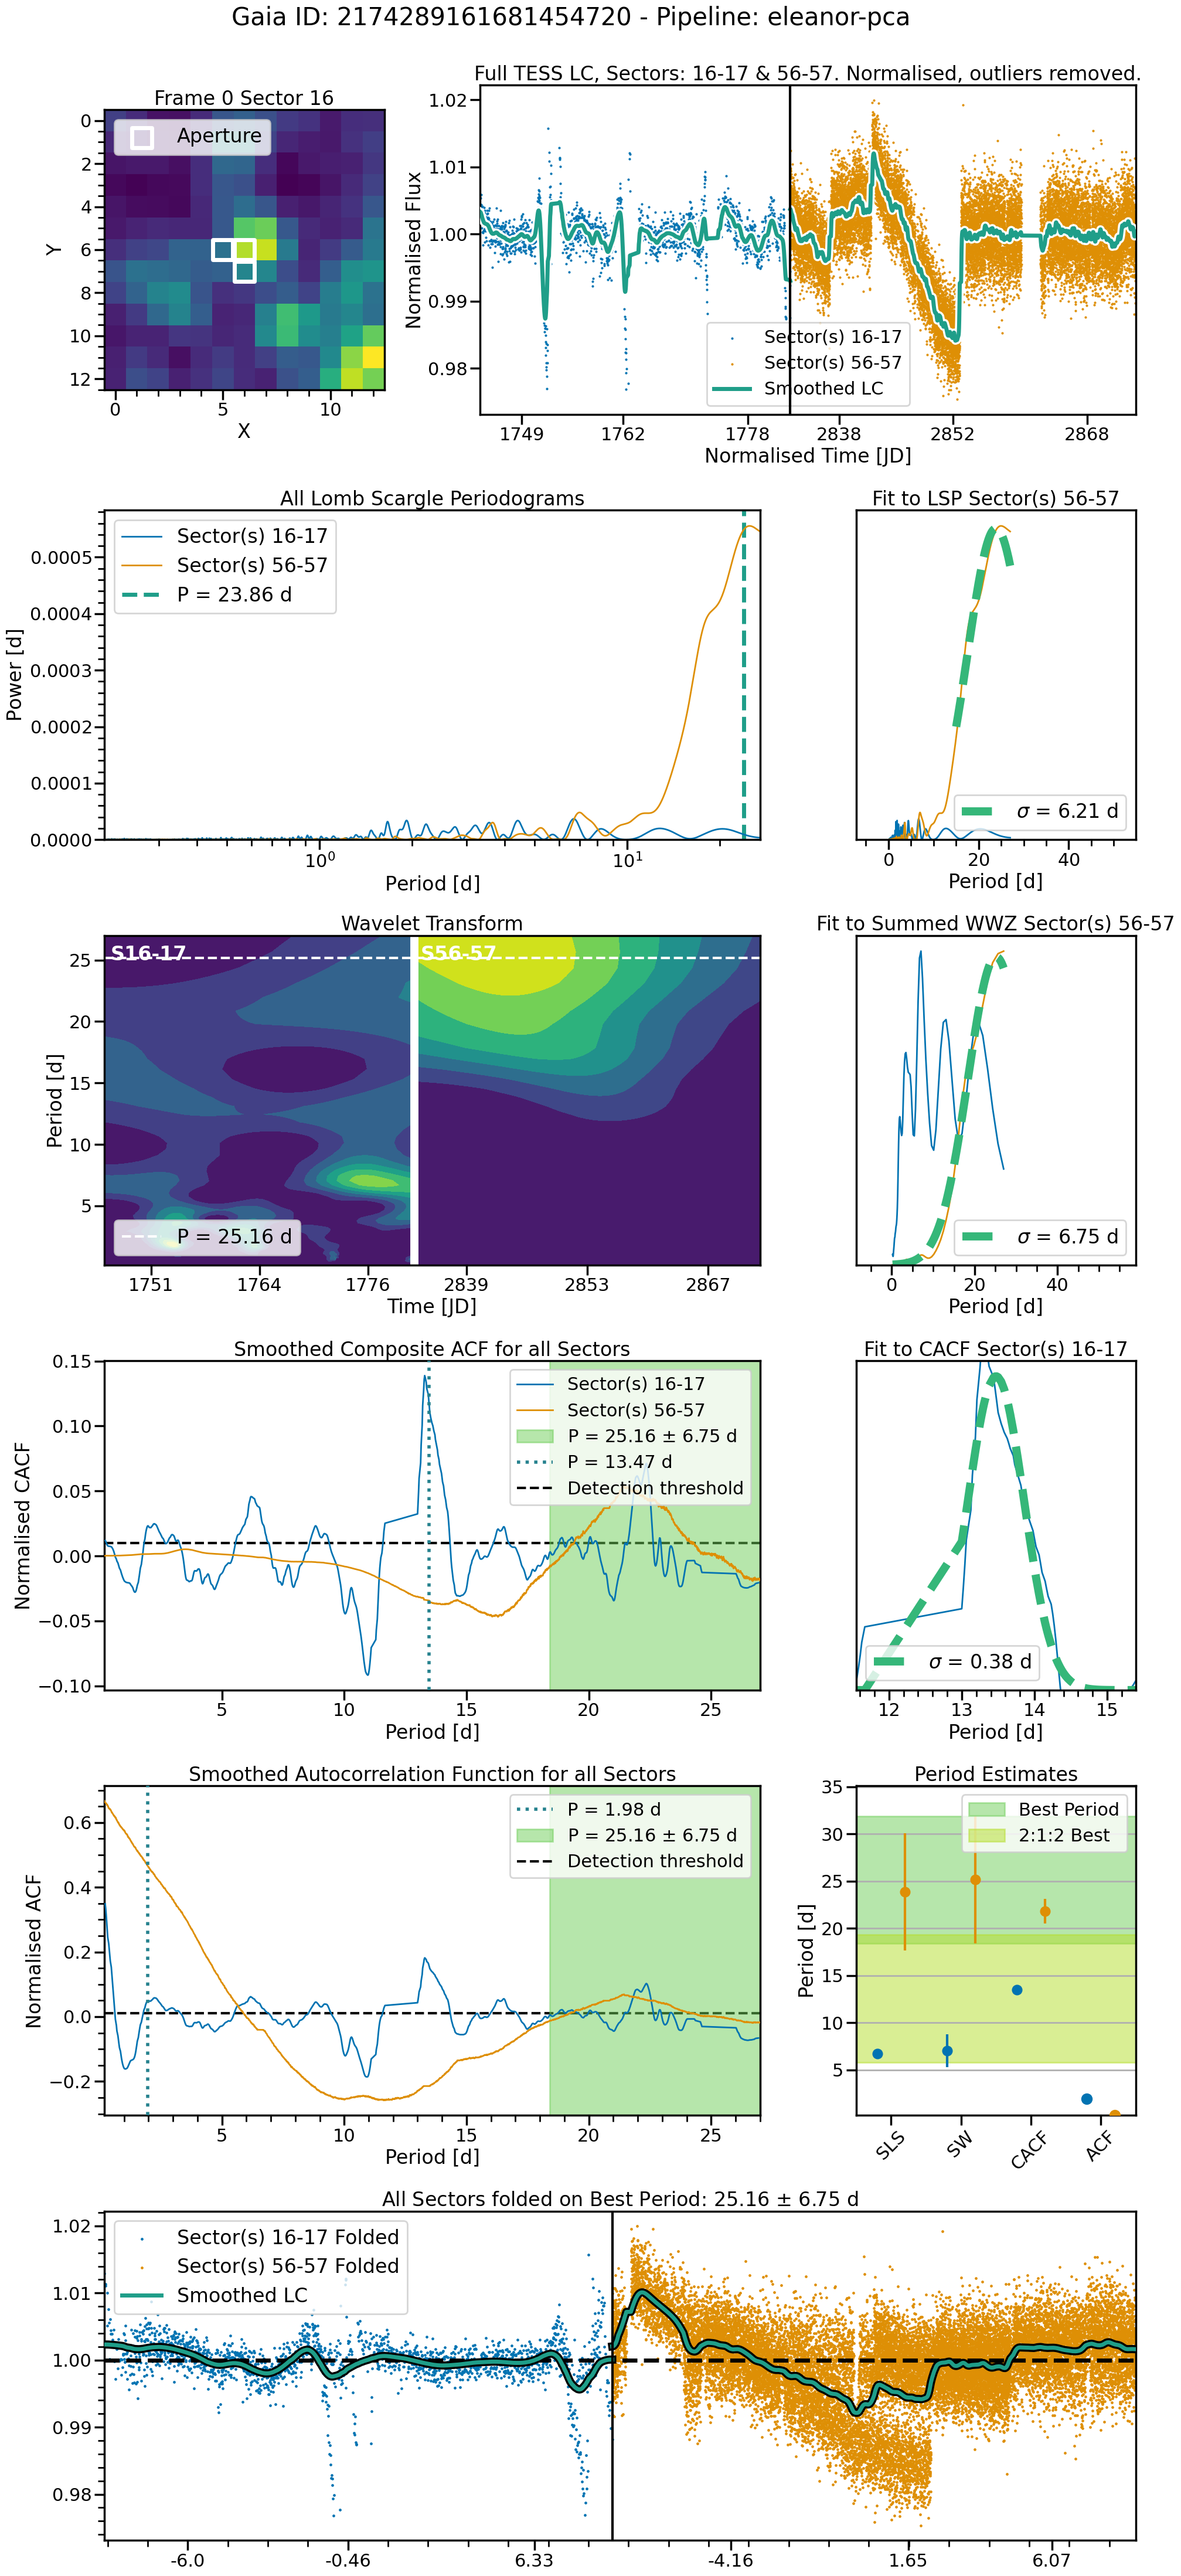

Target DR3 ID 2174289161681454720 has tesscut data available on MAST for Sectors 16, 17, 56, 57
Data already downloaded for Sector 16.
Data already downloaded for Sector 17.
Data already downloaded for Sector 56.
Data already downloaded for Sector 57.
### Running Simple Astropy Lomb-Scargle on Sector 16-17 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16-17 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###


 29%|███████████▉                             | 222/760 [00:05<00:12, 42.45it/s]

In [ ]:
for p in list(pipelines):
    j.pipeline = p
    j.pl = pipelines[j.pipeline]
    j.run()
    plt.show()